# PRESENTATION
This notebook uses some personal data on ATP tennis matches since 2013.
The **data** includes a lot of common statistics about each match:
- result
- score
- points won on serve
- CourtId: 1 to 6: "Hard", "Clay", "Indoor", "Carpet", "Grass", "Acrylic"
- aces...

Each match is made of 2 rows:
- the first row contains the stats for the first player
- the second row for the second player

It also includes some personal stats I made:
- AvgAceRateP: the average ace rate of the player (on clay or non clay surface) before the match. It is calculated from all the matches on this specficic surface over the past 3 seasons and weighted by date of season.
- AvgAceRateOpp: the average conceded ace rate of the opponent (on clay or non clay surface) before the match. It is calculated from all the matches on this specficic surface over the past 3 seasons and weighted by date of season.
- TrnSpeed: the speed fo the tournament (standard speed is 1.0)

The **goal** here is to find the best way to **predict the actual rate of a player one match** from the 3 features above.
We will use the actual ace rate of a match to train the model.

Source: https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner

**The notebook is organized as follows:**

* **[Part 0: Imports, Settings and switches, Global functions](#Part-0-:-Imports,-Settings,-Functions)**  
import libraries  
settings for number of cross validations  
define functions that are used often

* **[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)**  
Get an overview of the features (numerical and categorical) and first look on the target variable  
Relation of all features to target SalePrice  
Determine the columns that show strong correlation to target  

* **[Part 2: Data wrangling](#Part-2:-Data-wrangling)**  

* **[Part 3: Analysis of the couples AvgAceRateP/AvgAceRateOpp](#Part-3:-Analysis-of-the-couples-AvgAceRateP/AvgAceRateOpp)**  

* **[Part 4: Scikit-learn basic regression models and comparison of results](#Part-4:-Scikit-learn-basic-regression-models-and-comparison-of-results)**  
implement GridsearchCV with RMSE metric for Hyperparameter tuning  
based on RMSE metric, compare performance of the regressors with their optimized parameters,  
then explore correlation of the predictions and make submission with mean of best models  

Note on scores:  
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Part 0 : Imports, Settings, Functions

In [1]:
def get_query_surface(index_surface: str)->str:
    """Return the clause of the query for the surface
    Example: 'CourtId=="Clay" '
    Parameters
    ----------
    index_surface : str
        And index between 0 and 4 for the surface
        (NonClay=0,Clay=1,Hard=2,Indoor=3,Grass=4)
    Raises
    ------
    Exception
        If the index_surface is incorrect
    """
    index_surface = str(index_surface)
    str_clause_surface = ''
    if (index_surface =='1'):
        strClauseSurface = 'CourtId==2 '
    elif (index_surface =='0'):
        strClauseSurface = 'CourtId!=2 '
    elif (index_surface =='2'):
        strClauseSurface = 'CourtId==1 '
    elif (index_surface =='3'):
        strClauseSurface = 'CourtId==3 '
    elif (index_surface =='4'):
        strClauseSurface = 'CourtId==5 '
    else :
        raise Exception("indexSurface is incorrect for get_query_surface(indexSurface)")# + get_query_surface.__doc__)
    return strClauseSurface

## Import Libraries

In [2]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

## Settings

In [3]:
nr_cv=5 #number of folds for K-fold CV

## Load Data

In [4]:
#LOAD DATA
yrstart=2013
yrend=2021
dfMatches=pd.DataFrame()
for year in range(yrend, yrstart-1,-1):
    #dfcha=pd.read_csv((r"https://raw.githubusercontent.com/damienld/tennis_atp/master/atp_matches_qual_chall_{0}.csv").format(str(year)),index_col=0)
    dfyear=pd.read_csv(("./Data/ATP{0}_all_matches.csv").format(str(year)), parse_dates = ['Date'])
    dfMatches=pd.concat([dfMatches,dfyear],axis=0)
dfMatches = dfMatches.sort_values(by="Date", ascending=False)   
dfMatches.info()
dfMatches["CourtId"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217450 entries, 1350 to 26023
Data columns (total 50 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               217450 non-null  datetime64[ns]
 1   TrnId              217450 non-null  int64         
 2   Trn                217450 non-null  object        
 3   TrnRk              217450 non-null  int64         
 4   TrnSite            186462 non-null  float64       
 5   TrnSpeed           167538 non-null  float64       
 6   TrnSpeedNb         217450 non-null  int64         
 7   CourtId            217450 non-null  int64         
 8   RoundId            217450 non-null  int64         
 9   Round              217450 non-null  object        
 10  P1Id               217450 non-null  int64         
 11  P1                 217450 non-null  object        
 12  P2Id               217450 non-null  int64         
 13  P2                 217450 non-null  object

2    90650
1    75808
3    35658
5    11712
4     3622
Name: CourtId, dtype: int64

In [5]:
import skopt
print('skopt %s' % skopt.__version__)

skopt 0.9.0


## CLEAN / FILTER Data
- on user selected surface (input)
- where the aces data are valid

In [6]:
#USER can select the surface
dict_surfaces = {0: "NonClay", 1:"Clay", 2:"Hard", 3: "Indoor",4: "Grass"}
print("SELECT surface:" + str(dict_surfaces))
index_sel = int(input())
print(dict_surfaces.get(index_sel))
strClauseSurface = get_query_surface(index_sel)

#FILTER the dataframe for the Surface
dfMatchesForTrn = dfMatches.copy(deep=True)
#keep only if TrnSpeed > 0 & TrnSpeedNb > 9
dfMatchesForTrn = dfMatchesForTrn[dfMatchesForTrn['TrnSpeed'] > 0]
dfMatchesForTrn = dfMatchesForTrn[dfMatchesForTrn['TrnSpeedNb'] > 9]
query_filter = strClauseSurface + ' & IsValidData >0 & IsEnoughData3>0 & AvgAceRateP>0  & AvgAceRateOpp>0' # & AceRatePlayer>0
#no qualifying matches and no exhib/DC/juniors and no itf
query_filter += ' & RoundId>=4 & TrnRk <= 4  & TrnRk >= 1' # & AceRatePlayer>0
print(query_filter)
dfMatchesForTrn = dfMatchesForTrn.query(query_filter)
#print(dfMatchesForTrn)
print('nb matches: ' + str(len(dfMatchesForTrn)))

SELECT surface:{0: 'NonClay', 1: 'Clay', 2: 'Hard', 3: 'Indoor', 4: 'Grass'}
0
NonClay
CourtId!=2  & IsValidData >0 & IsEnoughData3>0 & AvgAceRateP>0  & AvgAceRateOpp>0 & RoundId>=4 & TrnRk <= 4  & TrnRk >= 1
nb matches: 48518


In [7]:
df=dfMatchesForTrn[["AvgAceRateP","AvgAceRateOpp","TrnSpeed","AceRatePlayer"]]
df=df.dropna()

target_name = 'AceRatePlayer'

# Part 1: Exploratory Data Analysis

## 1.1 Overview of features and relation to target

Let's get a first overview of the train and test dataset  
How many rows and columns are there?  
What are the names of the features (columns)?  
Which features are numerical, which are categorical?  
How many values are missing?  
The **shape** and **info** methods answer these questions  
**head** displays some rows of the dataset  
**describe** gives a summary of the statistics (only for numerical columns)

### 1.1.a) shape, info, head and describe

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48518 entries, 1374 to 24614
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AvgAceRateP    48518 non-null  float64
 1   AvgAceRateOpp  48518 non-null  float64
 2   TrnSpeed       48518 non-null  float64
 3   AceRatePlayer  48518 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


In [9]:
df.head(2)

,AvgAceRateP,AvgAceRateOpp,TrnSpeed,AceRatePlayer
1374,12.3,8.8,1.33,14.1
1380,9.6,11.2,0.88,30.8


In [10]:
df.describe()    

,AvgAceRateP,AvgAceRateOpp,TrnSpeed,AceRatePlayer
count,48518.000000,48518.000000,48518.000000,48518.000000
mean,8.624677,7.952537,0.980634,8.490669
std,3.961292,1.822772,0.127779,6.318774
min,1.500000,3.000000,0.600000,0.000000
25%,5.800000,6.600000,0.890000,3.900000
50%,7.900000,7.900000,0.970000,7.200000
75%,10.600000,9.200000,1.060000,11.500000
max,26.800000,19.000000,1.420000,62.500000


### 1.1.b) The target variable : Distribution of AceRatePlayer

D:\Programmes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.364664
Kurtosis: 2.799627


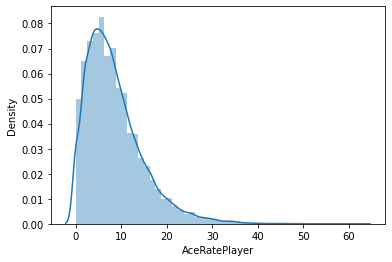

In [11]:
sns.distplot(df[target_name]);
#skewness and kurtosis
print("Skewness: %f" % df[target_name].skew())
print("Kurtosis: %f" % df[target_name].kurt())

As we see, the target variable is **NOT NORMALLY distributed**.  
This can reduce the performance of the ML regression models because some assume normal distribution,   
see [sklearn info on preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)  

Variable **RIGHT-SKEWED** (skewed means not symetric)
=> we make a **LOG transformation** to improved the distribution.  

If **LEFT-SKEWED**
=> we would try **exponential or SQUARE functions**

If the skewness is between -0.5 & 0.5, the data are nearly symmetrical.

If the skewness is between -1 & -0.5 (negative skewed) or between 0.5 & 1(positive skewed), the data are slightly skewed.

If the skewness is lower than -1 (negative skewed) or greater than 1 (positive skewed), the data are extremely skewed.

That said if you are sure that those points which skewed the distribution are OUTLIERS then they should be filtered out.

D:\Programmes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -2.929168
Kurtosis: 9.402934


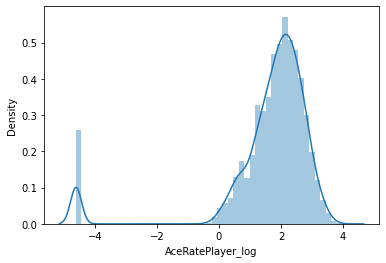

In [12]:
target_name_log = target_name + "_log" 
df[target_name_log] = np.log(df[target_name]+0.01) #+0.01 to prevent log(0)
sns.distplot(df[target_name_log]);
# skewness and kurtosis
print("Skewness: %f" % df[target_name_log].skew())
print("Kurtosis: %f" % df[target_name_log].kurt())

Let's remove the outliers

In [13]:
print("{x} rows before".format(x=len(df)))
df=df[df[target_name]>0]
print("{x} rows after".format(x=len(df)))

48518 rows before
46320 rows after


D:\Programmes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -0.410478
Kurtosis: -0.186593


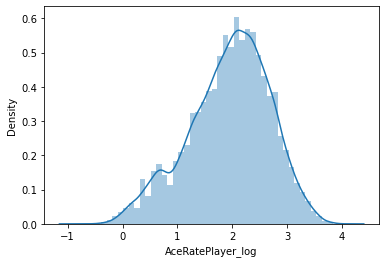

In [14]:
#lets update/see the log distribution now
df[target_name_log] = np.log(df[target_name]+0.01) #+0.01 to prevent log(0)
sns.distplot(df[target_name_log]);
# skewness and kurtosis
print("Skewness: %f" % df[target_name_log].skew())
print("Kurtosis: %f" % df[target_name_log].kurt())

Decent disttibution by using LOG transformation

In [15]:
#remove the non log value
df = df.drop([target_name],axis=1)

### 1.1.c) Numerical and Categorical features

In [16]:
numerical_feats = df.dtypes[df.dtypes != "object"].index
print("Number of NUMERICAL features: ", len(numerical_feats))
print(df[numerical_feats].columns)

print("*"*100)
categorical_feats = df.dtypes[df.dtypes == "object"].index
print("Number of CATEGORICAL features: ", len(categorical_feats))
print(df[categorical_feats].columns)

Number of NUMERICAL features:  4
Index(['AvgAceRateP', 'AvgAceRateOpp', 'TrnSpeed', 'AceRatePlayer_log'], dtype='object')
****************************************************************************************************
Number of CATEGORICAL features:  0
Index([], dtype='object')


### 1.1.d) List of features with missing values

In [17]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
AvgAceRateP,0,0.0
AvgAceRateOpp,0,0.0
TrnSpeed,0,0.0
AceRatePlayer_log,0,0.0


**Filling missing values**  
For a few columns there is lots of NaN entries.  
However, reading the data description we find this is not missing data:  
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.  

In [18]:
#FILL NA by None for a list of columns
# columns names where NaN values have meaning e.g. no pool etc.
cols_fillna = []

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df[col].fillna('None',inplace=True)

In [19]:
# FILL NA with mean for the remaining columns
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

df.fillna(df.mean(), inplace=True)

### 1.1.e) log transform for Features
Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis:

In [20]:
for col in numerical_feats:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df[col].skew()) , 
          '   ' ,
          'Kurtosis: {:06.2f}'.format(df[col].kurt())  
         )

AvgAceRateP     Skewness: 01.45     Kurtosis: 003.27
AvgAceRateOpp   Skewness: 00.37     Kurtosis: 000.34
TrnSpeed        Skewness: 00.29     Kurtosis: 000.10
AceRatePlayer_log Skewness: -0.41     Kurtosis: -00.19


D:\Programmes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 1.446122
Kurtosis: 3.269134


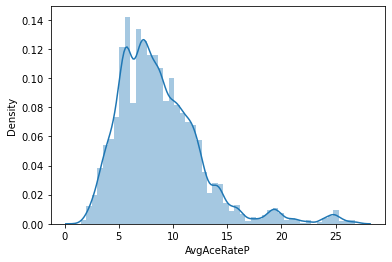

In [21]:
#let's try to improve the skewness of the columns where needed
cols_to_skew=['AvgAceRateP']
for colname in cols_to_skew:
    sns.distplot(df[colname]);
    #skewness and kurtosis
    print("Skewness: %f" % df[colname].skew())
    print("Kurtosis: %f" % df[colname].kurt())


D:\Programmes\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -0.083705
Kurtosis: 0.257682


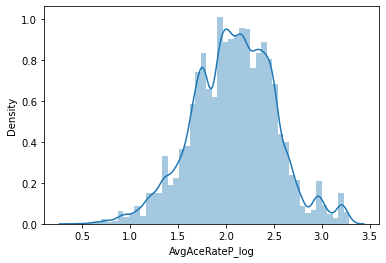

In [22]:
for colname in cols_to_skew:
    colname_log=colname+"_log"
    df[colname_log] = np.log(df[colname]+0.01)
    sns.distplot(df[colname_log]);
    #skewness and kurtosis
    print("Skewness: %f" % df[colname_log].skew())
    print("Kurtosis: %f" % df[colname_log].kurt())

In [23]:
df = df.drop([colname],axis=1)

## 1.2 Relation of features to target

### 1.2.a) Plots of relation to target for all numerical features

D:\Programmes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Programmes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Programmes\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Programmes\Anaconda\lib\s

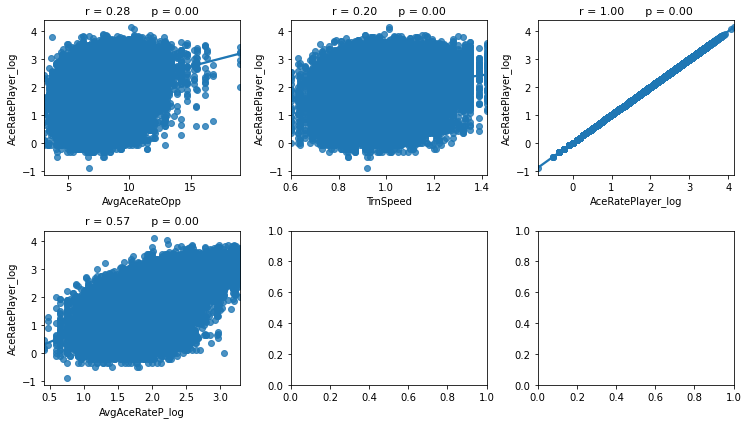

In [24]:
from scipy import stats
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

li_num_feats = list(numerical_feats)
li_plot_num_feats = [c for c in list(df.columns)]


for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[i]], df[target_name_log], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[i]], df[target_name_log])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()   

In [25]:
import seaborn as sns

def plot_corr_matrix(df: pd.DataFrame, nr_c: int, targ: str) :
    """
    Display a Heatmap of the correlations

    Parameters
    ----------
    df : dataframe (incl. the target column)
    nr_c : number of columns to use from df (it will select the ones with highest absolute correlation)
    targ : name of the column for the target variable
    """    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

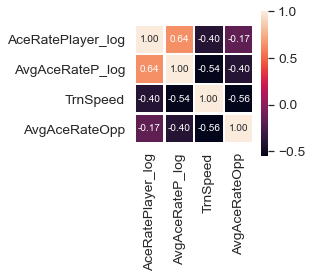

In [26]:
# calculate the correlation between variables in order to check the most correlated with Y
correlation = df.corr(method='pearson')

plot_corr_matrix(correlation, len(df.columns), "AceRatePlayer_log")

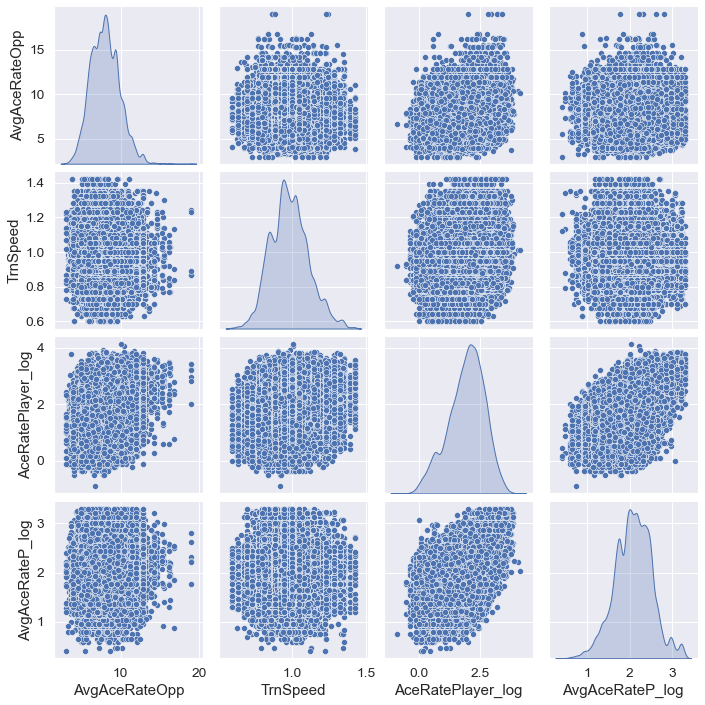

In [27]:
import seaborn as sns
sns.pairplot(df, diag_kind="kde")

**Conclusion from EDA on numerical columns:**

If we had more features, it could be worth dropping th eones who are below a threshold for the correlation value with the target.

### 1.2.b) List of categorical features and their unique values

In [28]:
for catg in list(categorical_feats) :
    print(df_train[catg].value_counts())
    print('#'*50)

### 1.2.c) Relation to Target for all categorical features

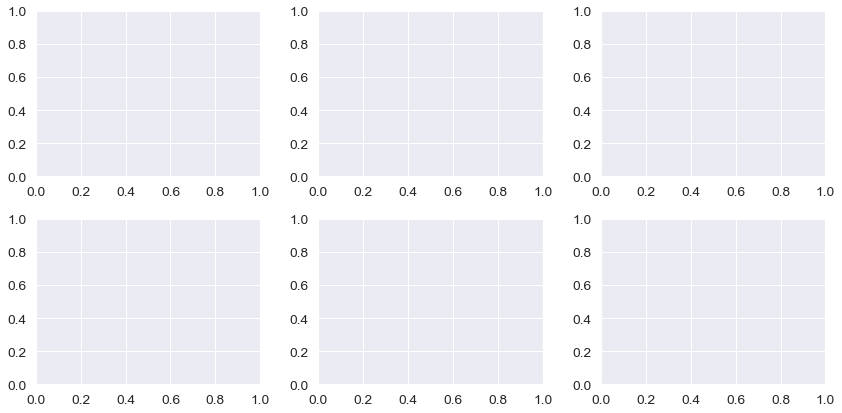

In [29]:
li_cat_feats = list(categorical_feats)
nr_rows = 2
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

In [30]:
#TODO Keep only the categorical features with strong correlation with the target

# Part 2 - Data wrangling

**Drop all columns with only small correlation to Target**  
**Transform Categorical to numerical **  
**Handling columns with missing data**  
**Log values**  
**Drop all columns with strong correlation to similar features**  

Numerical columns : drop similar and low correlation

Categorical columns : Transform  to numerical

### 2-1 Dropping all columns with weak correlation to Target

### 2-2 Convert categorical columns to numerical  
For those categorcial features where the EDA with boxplots seem to show a strong dependence of the Target on the category, we transform the columns to numerical.
To investigate the relation of the categories to Target in more detail, we make violinplots for these features 
Also, we look at the mean of Target as function of category.

In [31]:
for catg in list(categorical_feats) :
    #sns.catplot(x=catg, y=target, data=df_train, kind='boxen')
    sns.violinplot(x=catg, y=target, data=df)
    plt.show()
    #sns.boxenplot(x=catg, y=target, data=df_train)
    #bp = df_train.boxplot(column=[target], by=catg)
    
    

### 2-3 Check for Multicollinearity

**Of those couples of features with strong correlation between them, we drop the one that has smaller correlation coeffiecient to Target.**

### 2-4 Standardization

In [32]:
y_ml = df[target_name_log]
X_ml = df.drop(target_name_log, axis=1)
X_train_ml, X_test_ml, y_train, y_test = train_test_split(X_ml, y_ml, test_size=0.2)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train_ml)
X_test = sc.transform(X_test_ml)

print(y_train)

2159     1.570697
23533    1.388791
13343    2.785628
19837    1.776646
25432    2.721953
           ...   
20964    3.653511
25425    2.042518
12892    2.996232
21581    0.959350
7526     2.252344
Name: AceRatePlayer_log, Length: 37056, dtype: float64


# Part 3: Analysis of the couples AvgAceRateP/AvgAceRateOpp
Let's observe the couples of values and their actual result.

STEPS:
- round the values so they can be groupped
- make a pivot table indexed by AvgAceRateP,AvgAceRateOpp
- keep only when the number of rows is a minimum (20)

In [33]:
dfMatchesForTrn2=dfMatchesForTrn[["AceRatePlayer","AvgAceRateP","AvgAceRateOpp"]]
#round the values
#dfMatchesForTrn2.AceRatePlayer=dfMatchesForTrn2.AceRatePlayer.round()
dfMatchesForTrn2.AvgAceRateP=dfMatchesForTrn2.AvgAceRateP.round()
dfMatchesForTrn2.AvgAceRateOpp=dfMatchesForTrn2.AvgAceRateOpp.round()
#Make a pivot table indexed by the differents couples of features
dfpivot_aces=pd.pivot_table(dfMatchesForTrn2,index=["AvgAceRateP","AvgAceRateOpp"],aggfunc=["median", "count"])
#Keep only when the number of rows is a minimum
dfpivot_aces=dfpivot_aces[dfpivot_aces["count"]["AceRatePlayer"]>20]
dfpivot_aces=dfpivot_aces.reset_index()
dfpivot_aces
dfpivot_aces.to_csv("Hard-men.csv")
#dfpivot_aces[dfpivot_aces.AvgAceRateOpp==7]#.head(22)

D:\Programmes\Anaconda\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [34]:
dfpivot_aces[dfpivot_aces.AvgAceRateP==7].head(22)

,AvgAceRateP,AvgAceRateOpp,median,count
,,,AceRatePlayer,AceRatePlayer
45,7.0,4.0,3.70,111
46,7.0,5.0,4.20,313
47,7.0,6.0,5.00,935
48,7.0,7.0,5.60,986
49,7.0,8.0,6.60,1306
50,7.0,9.0,7.30,917
51,7.0,10.0,7.80,681
52,7.0,11.0,8.70,224
53,7.0,12.0,8.35,112


# Part 4: Scikit-learn basic regression models and comparison of results

**Test simple sklearn models and compare by metrics**

**We test the following Regressors from scikit-learn:**  
LinearRegression  
Ridge  
Lasso  
Elastic Net  
Stochastic Gradient Descent  
DecisionTreeRegressor  
RandomForestRegressor  
SVR 

In [35]:
# importing enum for enumerations
import enum
 
# creating enumerations using class
class RegModel(enum.Enum):
    linear = 1
    poly = 2
    ridge = 3
    lasso = 4
    elastic_Net = 5
    stochastic_Gradient_Descent = 6
    decisionTreeRegressor = 7
    randomForestRegressor = 8
    knn = 9

EVALUATION
we compare the actual values and predicted values to calculate the accuracy of a regression model. Evaluation metrics provide a key role in the development of a model, as it provides insight to areas that require improvement.

METRICS:
- Mean absolute error: It is the mean of the absolute value of the errors. This is the easiest of the metrics to understand since it’s just average error.
- Mean Squared Error (MSE): Mean Squared Error (MSE) is the mean of the squared error. It’s more popular than Mean absolute error because the focus is geared more towards large errors. This is due to the squared term exponentially increasing larger errors in comparison to smaller ones.
- Root Mean Squared Error (RMSE): R-squared is not error, but is a popular metric for accuracy of your model. It represents how close the data are to the fitted regression line. The higher the R-squared, the better the model fits your data. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

In [37]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

score_calc = 'neg_mean_squared_error'
def print_metrics(y_test, y_pred):    
    print('MAE: %.2f' % mean_absolute_error(y_test, y_pred))
    print('RMSE: %.2f' % mean_squared_error(y_test, y_pred, squared=False))
    print('R2-score: %.2f' % r2_score(y_test, y_pred))
    
def get_best_score(grid):    
    #print(grid.best_estimator_)
    best_score = np.sqrt(-grid.best_score_)
    #print(best_score)    
    #print(grid.best_params_)
    return best_score

def apply_allmodels(X, y, n_splits):
    nr_features = X_train.shape[1]
    best_score = 10000
    best_params = None
    best_model = None
    for model in (RegModel):
        grid_search_results=apply_model(X, y, model, n_splits, nr_features)
        score = get_best_score(grid_search_results)          
        if (grid_search_results != None and score < best_score):
            best_score = get_best_score(grid_search_results)
            best_params = grid_search_results.best_params_
            best_model = model
    print("\n=> Best of all: %f using %s with %s" % (best_score, best_params, best_model))     
        
def apply_model(X, y, sel_model: RegModel, n_splits, nr_features):
    """
    Apply K-fold and GridSearchCV on the @sel_model
    Returns gridsearch result
    """    
    if (sel_model == RegModel.linear):
        model = LinearRegression()
        parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    elif (sel_model == RegModel.poly):
        print("Polnomial degree 2")
        model = LinearRegression()
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X = poly.fit_transform(X)
        parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    elif (sel_model == RegModel.ridge):
        model = Ridge()
        parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}
    elif (sel_model == RegModel.lasso):
        model = Lasso()
        parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
    elif (sel_model == RegModel.elastic_Net):
        model = ElasticNet()
        parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
    elif (sel_model == RegModel.stochastic_Gradient_Descent):
        model = SGDRegressor()
        parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
    elif (sel_model == RegModel.decisionTreeRegressor):
        model = DecisionTreeRegressor()
        parameters = {}#{ 'max_features' : [nr_features-1]}
    elif (sel_model == RegModel.randomForestRegressor):
        model = RandomForestRegressor()
        parameters = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100]}
    elif (sel_model == RegModel.knn):
        model = KNeighborsRegressor()
        parameters = {'n_neighbors' : [3,5,7,10] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
    else :
        return #raise Exception("Incorrect model selected")
    # define grid search
    grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=1, cv=n_splits, scoring=score_calc)
    #OR BayesSearchCV(..)
    grid_result = grid_search.fit(X, y)
    # summarize results
    print("Best: %f using %s with %s\n" % (get_best_score(grid_result), grid_result.best_params_, grid_result.best_estimator_))
    return grid_result

apply_allmodels(X_train, y_train, nr_cv)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: 0.555604 using {'copy_X': True, 'fit_intercept': True, 'normalize': True} with LinearRegression(normalize=True)

Polnomial degree 2
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best: 0.553840 using {'copy_X': True, 'fit_intercept': True, 'normalize': True} with LinearRegression(normalize=True)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best: 0.555604 using {'alpha': 1, 'normalize': False, 'tol': 1e-06} with Ridge(alpha=1, tol=1e-06)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best: 0.555606 using {'alpha': 0.001, 'normalize': False, 'tol': 5e-05} with Lasso(alpha=0.001, tol=5e-05)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best: 0.557646 using {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.0001} with ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000)

Fitting 5 folds for each of 1 candi

D:\Programmes\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [-0.40993127 -0.4406081  -0.37032345 -0.40500375 -0.35168017 -0.38841575
 -0.33706607 -0.37469773 -0.41004952 -0.44075687 -0.37003689 -0.40488051
 -0.35154979 -0.38834346 -0.3371155  -0.37474632         nan         nan
         nan         nan         nan         nan         nan         nan]
  warnings.warn(


Best: 0.580574 using {'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'} with KNeighborsRegressor(algorithm='ball_tree', n_neighbors=10)


=> Best of all: 0.553840 using {'copy_X': True, 'fit_intercept': True, 'normalize': True} with RegModel.poly


### Linear Regression

In [40]:
lm=LinearRegression()
lm.fit(X_train, y_train)
#RESULTS
print('RESULTS FOR COURT:')
coeffsLRegression=lm.coef_
print(coeffsLRegression)
#print(pd.DataFrame({'estimated coeff':coeffsRegression}, index=X_train.columns))
coeff0LRegression= lm.intercept_
print(coeff0LRegression)
y_pred=lm.predict(X_test)
print_metrics(y_test, y_pred)

RESULTS FOR COURT:
[0.18885051 0.15530238 0.41662887]
1.9384473337355286
MAE: 0.43
RMSE: 0.55
R2-score: 0.45


In [ ]:
df2=dfMatchesForTrn[["AvgAceRateP","AvgAceRateOpp","TrnSpeed","AceRatePlayer"]]
df2=df2.dropna()
df2 = df2[df2["AvgAceRateP"]>11]
y2 = df2["AceRatePlayer"]
X2 = df2.drop(["AceRatePlayer", "TrnSpeed"], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
lm=LinearRegression()
lm.fit(X_train2, y_train2)
#RESULTS
print('COEFFS AceP(1) AceOpp(2) \n')
coeffsLRegression=lm.coef_
print(coeffsLRegression)

coeff0LRegression= lm.intercept_
print(coeff0LRegression)

y_pred2=lm.predict(X_test2)
print_metrics(y_test2, y_pred2)

# POLYNOMIAL REGRESSION (best model)

In [38]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

lpoly=LinearRegression()
lpoly.fit(X_train_poly, y_train)

#RESULTS
print('RESULTS FOR COURT:')
coeffsRegression=lpoly.coef_
print('COEFFS AceP(1) AceOpp(2) Trn(3) AceP**2(4) AceP*AceOpp(5) AceP*Trn(6) AceOpp**2(7) AceOpp*Trn(8) Trn**2(9)\n'+ str(coeffsRegression))
#print(pd.DataFrame({'estimated coeff':coeffsRegression}, index=X_train.columns))
coeff0Regression= lpoly.intercept_
print(coeff0Regression)

X_test_poly = poly.fit_transform(X_test)
y_pred=lpoly.predict(X_test_poly)

print_metrics(y_test, y_pred)

RESULTS FOR COURT:
COEFFS AceP(1) AceOpp(2) Trn(3) AceP**2(4) AceP*AceOpp(5) AceP*Trn(6) AceOpp**2(7) AceOpp*Trn(8) Trn**2(9)
[ 0.19549434  0.15625549  0.41887406 -0.0194142  -0.00264998 -0.00146014
 -0.0010224   0.00105715  0.02293373]
1.9359500664250942
MAE: 0.43
RMSE: 0.55
R2-score: 0.45


In [61]:
#SAME but WITHOUT TrnSpeed variable
df2=dfMatchesForTrn[["AvgAceRateP","AvgAceRateOpp","TrnSpeed","AceRatePlayer"]]
df2=df2.dropna()
df2 = df2[df2["AvgAceRateP"]>11]
y2 = df2["AceRatePlayer"]
X2 = df2.drop(["AceRatePlayer", "TrnSpeed"], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
lm=LinearRegression()
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly2 = poly.fit_transform(X_train2)

lm.fit(X_train_poly2, y_train2)
#RESULTS
print('COEFFS AceP(1) AceOpp(2) AceP**2(3) AceP*AceOpp(5) AceOpp**2(7)\n')
coeffsRegression=lm.coef_
print(coeffsRegression)
#print(pd.DataFrame({'estimated coeff':coeffsRegression}, index=X_train.columns))
coeff0Regression= lm.intercept_
print(coeff0LRegression)

X_test2_poly = poly.fit_transform(X_test2)

y_pred2=lm.predict(X_test2_poly)
print_metrics(y_test2, y_pred2)
print(X_test2)
print(X_test2_poly[0])
print(y_pred2[0])

COEFFS AceP(1) AceOpp(2) AceP**2(3) AceP*AceOpp(5) AceOpp**2(7)

[ 0.81980468  1.42874597 -0.00451782  0.04087354 -0.04769645]
1.9384473337355286
MAE: 4.74
RMSE: 6.13
R2-score: 0.34
       AvgAceRateP  AvgAceRateOpp
8726          16.2            7.7
22640         19.1            7.5
25112         19.8            6.0
20548         13.4            5.0
20456         11.5            9.8
...            ...            ...
13096         15.7            7.3
1015          14.2            6.7
22338         11.3            8.9
23863         19.1            6.3
446           14.4            8.6

[2110 rows x 2 columns]
[ 16.2    7.7  262.44 124.74  59.29]
15.759359478075682


Let's **apply the regression coefficients** (linear regression and polynomial regression) on our table dfpivot_aces.

We'll apply TrnSpeed=1 as it s the standard value (mean/median)

In [57]:
trnSpeed=1
dfpivot_aces["expAces_reg"] = \
[(coeff0LRegression+ace*coeffsLRegression[0]+acevs*coeffsLRegression[1]) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
#COEFFS AceP(1) AceOpp(2) Trn(3) AceP**2(4) AceP*AceOpp(5) AceP*Trn(6) AceOpp**2(7) AceOpp*Trn(8) Trn**2(9)
#[ 0.19549434  0.15625549  0.41887406 -0.0194142  -0.00264998 -0.00146014
# -0.0010224   0.00105715  0.02293373]
#1.9359500664250942
dfpivot_aces["expAces_poly"] = \
[(coeff0Regression+ace*coeffsRegression[0]+acevs*coeffsRegression[1]+trnSpeed*coeffsRegression[2]
  +ace**2*coeffsRegression[3]+ace*acevs*coeffsRegression[4] 
  +ace*trnSpeed*coeffsRegression[5]+acevs**2*coeffsRegression[6] \
  +acevs*trnSpeed*coeffsRegression[7] + trnSpeed**2*coeffsRegression[8]
 ) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
#dfpivot_aces["expAces_poly"] = np.exp(dfpivot_aces["expAces_poly"])
dfpivot_aces["expAces_reg_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_reg"]).abs()
dfpivot_aces["expAces_poly_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_poly"]).abs()
dfpivot_aces.iloc[61:80,:]

,AvgAceRateP,AvgAceRateOpp,median,count,expAces_reg,expAces_poly,expAces_reg_gap,expAces_poly_gap
,,,AceRatePlayer,AceRatePlayer,,,,
61,8.0,10.0,9.1,707,5.002275,3.946411,4.097725,5.153589
62,8.0,11.0,9.7,314,5.157578,4.061054,4.542422,5.638946
63,8.0,12.0,10.3,137,5.312880,4.173651,4.987120,6.126349
64,8.0,13.0,11.1,72,5.468182,4.284204,5.631818,6.815796
65,9.0,4.0,4.5,85,4.259311,3.069008,0.240689,1.430992
66,9.0,5.0,4.9,202,4.414614,3.193270,0.485386,1.706730
67,9.0,6.0,6.4,705,4.569916,3.315486,1.830084,3.084514
68,9.0,7.0,7.2,707,4.725219,3.435658,2.474781,3.764342
69,9.0,8.0,8.5,921,4.880521,3.553785,3.619479,4.946215


In [56]:
trnSpeed=1
dfpivot_aces["expAces_reg"] = \
[(coeff0LRegression+ace*coeffsLRegression[0]+acevs*coeffsLRegression[1]+trnSpeed*coeffsLRegression[2]) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
dfpivot_aces["expAces_poly"] = \
[(coeff0Regression+ace*coeffsRegression[0]+acevs*coeffsRegression[1]+trnSpeed*coeffsRegression[2]+ace**2*coeffsRegression[3]+ace*acevs*coeffsRegression[4]+ace*trnSpeed*coeffsRegression[5]+acevs**2*coeffsRegression[6]+acevs*trnSpeed*coeffsRegression[7]+trnSpeed**2*coeffsRegression[8]) for (ace, acevs) in zip(dfpivot_aces.AvgAceRateP, dfpivot_aces.AvgAceRateOpp)]
dfpivot_aces["expAces_reg_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_reg"]).abs()
dfpivot_aces["expAces_poly_gap"] = (dfpivot_aces["median"]["AceRatePlayer"]-dfpivot_aces["expAces_poly"]).abs()
dfpivot_aces.iloc[61:80,:]

,AvgAceRateP,AvgAceRateOpp,median,count,expAces_reg,expAces_poly,expAces_reg_gap,expAces_poly_gap
,,,AceRatePlayer,AceRatePlayer,,,,
61,8.0,10.0,9.1,707,5.418904,3.946411,3.681096,5.153589
62,8.0,11.0,9.7,314,5.574206,4.061054,4.125794,5.638946
63,8.0,12.0,10.3,137,5.729509,4.173651,4.570491,6.126349
64,8.0,13.0,11.1,72,5.884811,4.284204,5.215189,6.815796
65,9.0,4.0,4.5,85,4.675940,3.069008,0.175940,1.430992
66,9.0,5.0,4.9,202,4.831243,3.193270,0.068757,1.706730
67,9.0,6.0,6.4,705,4.986545,3.315486,1.413455,3.084514
68,9.0,7.0,7.2,707,5.141847,3.435658,2.058153,3.764342
69,9.0,8.0,8.5,921,5.297150,3.553785,3.202850,4.946215


# TODO

# Application of Deep Learning using Keras library
Here is the deep learning model mentioned. A sequential model has been used. The model has been created as a function named build_model so that we can call it anytime it is required in the process. The model has two connected hidden layers with a Rectified Linear Unit (relu) function and an output layer with a linear function.

The hidden layers have 12 and 8 neurons respectively with all the 8 input variables. Mean Squared Error is the loss function here as it is the most common loss function in case of regression problems.

#TODO
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
  model = keras.Sequential([
    layers.Dense(12,kernel_initializer='normal', activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='linear')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model
model = build_model()
model.summary()

def indexCoeff0ByCourt(nameCourt):
    switcher={
            'Clay':2,
            'Grass':3,
            'Hard':4,
            'I.hard':5
            }
    return switcher.get(nameCourt)

class TournamentStats:
    def __init__(self,id,dateT, name, speed, court,level,location
                 , sumActual, sumExp, nbMatches, coeff0Regression, coeffRegAceFor,coeffRegAceVs):
        self.id=id
        self.dateT = dateT
        self.name = name
        self.speed = speed
        self.court = court
        self.level=level
        self.location=location
        self.sumActual=sumActual
        self.sumExp=sumExp
        self.nbMatches=nbMatches
        self.coeff0Regression=coeff0Regression
        self.coeffRegAceFor=coeffRegAceFor
        self.coeffRegAceVs=coeffRegAceVs
    def __repr__(self):
        return '{},{},{},{},{},{},{},{},{},{},{},{},{}'.format(self.name,self.id,round(self.speed,2),
                                    self.dateT, self.court, self.level, self.location,
                                    round(self.sumActual,2), round(self.sumExp,2), self.nbMatches,
                                    round(self.coeff0Regression,2),round(self.coeffRegAceFor,2)
                                    ,round(self.coeffRegAceVs,2))
    def __cmp__(self, other):
        if hasattr(other, 'speed'):
            return self.speed.__cmp__(other.speed)
    def isCourt(self, courtName):
        return (courtName==self.court)
    @staticmethod
    def FilterByCourtName(list, courtName):
        return filter(isCourt(courtName), list)

def getTrnsSpeeds(listTrnIds, dataFromFile, coeffsRegression, coeff0Regression):
"""
Calculate the Speed of a Tournament (difference between Actual Aces and Expectes Aces)
"""
    listTrn=[]
    for trnId in listTrnIds:
        strClauseTrn = 'TrnId=='+str(trnId)+' & '
        dfMatchesForTrn=dataFromFile.copy(deep=True)
        dfMatchesForTrn.dropna()
        dfMatchesForTrn = dfMatchesForTrn.replace('NaN',-1).query(strClauseTrn + 'IsValidData>0 & IsEnoughData>0 & AceRatePlayer>=0 & AvgAceRateP>0  & AvgAceRateOpp>0')
        courtCoeff0Reg = 0
        #print('Coeff0 for Court=' + str(courtCoeff0Reg))
        #surface not taken into account here!! else add courtCoeff0Reg below
        expectedAce = (courtCoeff0Reg+coeff0Regression+coeffsRegression[0]*dfMatchesForTrn['AvgAceRateP']+coeffsRegression[1]*dfMatchesForTrn['AvgAceRateOpp'])
        expectedAce= [max(t, 0.01) for t in expectedAce]  #no negative values
        #diff=df['AceRatePlayer']-expectedAce
        #diff= max(diff, 0.01)
        sumActual=sum(dfMatchesForTrn['AceRatePlayer'])
        sumExp=sum(expectedAce)
        #print(df.iloc[0,2]+':'+str(statistics.mean(diff)))
        #print('Sum Ace Rates:'+str(sumActual))
        #print('Sum Exp Rates:'+str(sumExp))
        #print(df.iloc[0,0] + df.iloc[0,2]+'Diff:'+str(sumActual/sumExp))
        trn=TournamentStats(dfMatchesForTrn.iloc[0,0], dfMatchesForTrn.iloc[0,1], dfMatchesForTrn.iloc[0,2]
                            , sumActual/sumExp, dfMatchesForTrn.iloc[0,5]
                            , dfMatchesForTrn.iloc[0,3], dfMatchesForTrn.iloc[0,4], sumActual, sumExp
                            , len(dfMatchesForTrn), coeff0Regression, coeffsRegression[0],coeffsRegression[1])
        #print(trn)
        listTrn.append(trn)
    #listTrnClay=[t for t in listTrn if (x.isCourt('Clay'))]
    #listTrnClay=filter(lambda x: x.isCourt('Clay'), listTrn)
    #list(listTrnClay)
    #listTrnClay.sort(key=lambda x: x.speed, reverse=True)
    #sorted(listTrnClay, key=lambda x: x.speed, reverse=True)
    listTrn.sort(key=lambda x: x.name, reverse=True)
    print(*listTrn, sep="\n")
    #listTrNonClay=list(filter(lambda x: not x.isCourt('Clay'), listTrn))
    #sorted(listTrNonClay, key=lambda x: x.speed, reverse=True)
    #print(*listTrNonClay, sep="\n")

def displayAllMatches(trnId, dataFromFile, coeffsRegression, coeff0Regression):
    df=dataFromFile.copy(deep=True)
    df.dropna()
    df = df.replace('NaN',-1).query('TrnId=='+trnId+' & IsValidData>0 & IsEnoughData>0 & AceRatePlayer>0 & AvgAceRateP>0  & AvgAceRateOpp>0')     
    print(df)
    for index, row in df.iterrows():
        print(row['Player']+' in '+ row['P1'] + '/' + row['P2'])
        courtCoeff0Reg = 0
        expectedAce = (courtCoeff0Reg+coeff0Regression+coeffsRegression[0]*row['AvgAceRateP']+coeffsRegression[1]*row['AvgAceRateOpp'])
        expectedAce= [max(t, 0.01) for t in expectedAce]  #no negative values
        print('Res=' + str(row['AceRatePlayer']) + ' - Expected=' + str(round(expectedAce,2)) + ' From ' + str(row['AvgAceRateP']) +' vs '  + str(row['AvgAceRateOpp']))
        diff=(row['AceRatePlayer']-expectedAce)
        #diff= min(max(diff, 0.01),1.99)
        print(diff)

# PLOTS

s1=[len( (dfMatchesForTrn[ (dfMatchesForTrn.AvgAceRateP.round()==round(valX)) & (dfMatchesForTrn.AceRatePlayer==round(valY))]) )/5 for valX,valY in zip(dfMatchesForTrn.AvgAceRateP,dfMatchesForTrn.AceRatePlayer)]
s2=[len( (dfMatchesForTrn[ (dfMatchesForTrn.AvgAceRateOpp.round()==round(valX)) & (dfMatchesForTrn.AceRatePlayer==round(valY))]) )/5 for valX,valY in zip(dfMatchesForTrn.AvgAceRateOpp,dfMatchesForTrn.AceRatePlayer)]


plt.scatter(X.AvgAceRateP.round(), Y.round(), color='blue',s=s1)
plt.xlabel('AvgAceRateP')
plt.ylabel('ActualAceRateP')
plt.show()
plt.scatter(X.AvgAceRateOpp.round(), Y.round(), color='red',s=s2)
plt.xlabel('AvgAceRateOpp')
plt.ylabel('ActualAceRateP')
plt.show()

plt.scatter(Y_test, y_pred, color = 'blue',s=1)
plt.xlabel('True Values [aces]')
plt.ylabel('Predictions [aces]')
plt.xlim([0,15])
plt.ylim([0,15])
plt.plot([0,15], [0,15])
f=X.AvgAceRateP*coeffsRegression[0]+X.AvgAceRateOpp*coeffsRegression[1]+X.TrnSpeed2*coeffsRegression[2]+lm.intercept_
print(f.iloc[0])
#plt.plot(X.AvgAceRateP,f, '-r')
#plt.plot(train_x, coeffsRegression[0]*train_x + regr.intercept_[0], '-r')